## Notebook that trains a Conditional GAN for generating galaxy patches conditioned on a size class
Implementation adapted from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
and
https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import save_image
import torchvision
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import pickle
from ast import literal_eval

# set up accordingly
data_dir = "../../data"            # directory with data files
labeled_image_dir = "labeled_patches"           # folder within data directory with labeled images (0, 1)
scored_image_dir = "scored_patches"             # folder within data directory with scored images
labeled_info = "labeled_patches_t5.csv"            # information about labeled galaxy patches
scored_info = "scored_patches_t5.csv"              # information about scored galaxy patches
scores = "scored.csv"                           # file within data directory with scored images' scores
device = torch.device("cuda")        # cuda or cpu
collab = False                        # google collab flag

In [12]:
# google collab
# mount drive, copy over data as zip and unzip it
if collab:
  from google.colab import drive
  drive.mount('/content/drive')
  collab_dir = "content"

  zip_path = os.path.join(data_dir, labeled_image_dir + '.zip')
  !cp '{zip_path}' .
  !unzip -q '{labeled_image_dir}'.zip
  # !mv labeled_patches labeled_patches_2
  !rm '{labeled_image_dir}'.zip

  zip_path = os.path.join(data_dir, scored_image_dir + '.zip')
  !cp '{zip_path}' .
  !unzip -q '{scored_image_dir}'.zip
  # !mv scored_patches scored_patches_2
  !rm '{scored_image_dir}'.zip
else:
  labeled_image_dir = os.path.join(data_dir,labeled_image_dir)
  scored_image_dir = os.path.join(data_dir,scored_image_dir)

In [4]:
class GalaxyDataset(torch.utils.data.Dataset):
    """
    Galaxy dataset class
    Builds a dataset from the labeled and scored images. 
    Requires a threshold score for scored images. 
    Images with a score below the threshold are not used.
    """

    def __init__(self, labeled_csv_file, labeled_image_dir, scored_csv_file=None, scored_image_dir=None, transform=None, size=(32, 32), scored_threshold=3, size_thresholds=[5, 10, 100, 200]):
        self.image_ids = pd.read_csv(labeled_csv_file, index_col="patch_id")
        if scored_csv_file is not None and scored_image_dir is not None:
          self.image_ids = self.image_ids.append(pd.read_csv(scored_csv_file, index_col="patch_id"))
        self.size = size
        self.samples = []
        self.labeled_image_dir = labeled_image_dir
        self.scored_image_dir = scored_image_dir
        self.transform = transform
        self.scored_threshold = scored_threshold
        self.sizes = []
        self.size_thresholds = size_thresholds
        self.load_dataset()

    def __len__(self):
        return len(self.samples)

    def load_dataset(self):
      i = 0
      print("Loading Dataset...")
      for id, data in self.image_ids.iterrows():
        # convert from string to tuple
        intensity = data.intensity
        if intensity < 30:
          continue
        
        size = data.size
        if size > 50:
          print(size)
        score = data.score
        if score == -1:
          img_name = os.path.join(self.labeled_image_dir,
                                  str(id))
        else:
          img_name = os.path.join(self.scored_image_dir,
                                  str(id))
        # labeled images have score of -1
        # have already been filtered so only real images are left
        if score == -1 or score > self.scored_threshold:
          i += 1
          if size > 50:
            print(i)
          self.samples.append(Image.open(img_name).convert('L'))
          self.sizes.append(np.digitize(size, self.size_thresholds, right=True))
        
      print("Dataset Loaded")

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.samples[idx]
        cls = self.sizes[idx]
        if self.transform:
            image = self.transform(image)

        return image, cls

In [13]:
batch_size = 64
size = (32, 32)
latent_dim = 100
size_thresholds=[50, 90]
n_classes = len(size_thresholds) + 1

train_transformation = torchvision.transforms.Compose([
                            # torchvision.transforms.RandomAffine(0, translate=(0.2, 0.2)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(0.5, 0.5) ## second normalization for tanh
])


train_dataset = GalaxyDataset(os.path.join(data_dir, labeled_info),
                              labeled_image_dir,
                              scored_csv_file=os.path.join(data_dir, scored_info),
                              scored_image_dir=scored_image_dir,
                              transform=train_transformation,
                              size=size,
                              scored_threshold=4,
                              size_thresholds=size_thresholds)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)
print("{} images loaded".format(len(train_dataset)))

Loading Dataset...
Dataset Loaded
8338 images loaded


0


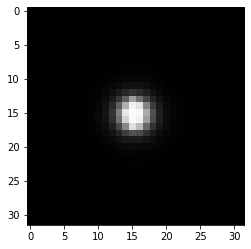

In [ ]:
plt.imshow(train_dataset[650][0].numpy().squeeze(), vmin=-1, vmax=1, cmap='gray')
print(train_dataset[650][1])

In [ ]:
gen_base_filters = 64
disc_base_filters = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label = nn.Sequential(
            nn.Embedding(n_classes, 50),
            nn.Linear(50, 8*8)
        )
        # self.latent_conv = nn.ConvTranspose2d( latent_dim, gen_base_filters * 4, 4, 1, 0, bias=False)
        self.latent = nn.Sequential(
            nn.Linear(latent_dim, 256*8*8),
            nn.BatchNorm1d(256*8*8),
            nn.LeakyReLU(0.2)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(257, 128, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            # nn.BatchNorm2d(gen_base_filters * 2),
            # state size. (gen_base_filters*2) x 8 x 8
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # nn.BatchNorm2d(gen_base_filters),
            # state size. (gen_base_filters) x 16 x 16
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, noise, label):
        label_filter = self.label(label)
        label_filter = label_filter.view(-1, 1, 8, 8)
        noise = self.latent(noise)
        # noise = self.latent_bn(noise)
        noise = noise.view(-1, 256, 8, 8)
        x = torch.cat([noise, label_filter], 1)
        return self.main(x)

In [ ]:
gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

Generator(
  (label): Sequential(
    (0): Embedding(4, 50)
    (1): Linear(in_features=50, out_features=64, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (main): Sequential(
    (0): ConvTranspose2d(257, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input is (nc) x 32 x 32
        self.label = nn.Sequential(
            nn.Embedding(n_classes, 50),
            nn.Linear(50, 32*32)
        )
        # self.label_bn = nn.BatchNorm1d(32*32)
        self.main = nn.Sequential(
            # state size. (disc_base_filters) x 32 x 32
            nn.Conv2d(2, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size. (disc_base_filters) x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm2d(disc_base_filters * 2),
            # state size. (disc_base_filters*2) x 8 x 8
            # nn.Conv2d(disc_base_filters * 2, disc_base_filters * 4, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm2d(disc_base_filters * 4),
            # # state size. (disc_base_filters*4) x 4 x 4
            # nn.Conv2d(disc_base_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(8*8*128, 1)
        )

    def forward(self, img, label):
        label_filter = self.label(label)
        label_filter = label_filter.view(-1, 1, 32, 32)
        x = torch.cat([img, label_filter], 1)
        return self.main(x)

In [ ]:
disc = Discriminator().to(device)
disc.apply(weights_init)
print(disc)

Discriminator(
  (label): Sequential(
    (0): Embedding(4, 50)
    (1): Linear(in_features=50, out_features=1024, bias=True)
  )
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten()
    (7): Linear(in_features=8192, out_features=1, bias=True)
  )
)


Set up training parameters

In [ ]:
G_losses = []
D_losses = []
iters = 0
img_list = []

# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(n_classes * 10, latent_dim, device=device)
fixed_cls = torch.LongTensor(np.repeat([i for i in range(n_classes)], 10)).to(device)
# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0
gen_lr = 1e-4
disc_lr = 4e-4
epochs = 500
# generator takes this many steps for every 1 of the discriminator
gen_steps = 1
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(disc.parameters(), lr=disc_lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=gen_lr, betas=(0.5, 0.999))

Function that takes one GAN step

In [ ]:
def gan_step(batch_num, batch, disc, gen):
  ############################
  # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
  ###########################
  ## Train with all-real batch
  disc.zero_grad()
  # Format batch
  (galaxy, cls) = data
  galaxy = galaxy.to(device)
  cls = cls.to(device)
  b_size = galaxy.size(0)
  label = torch.full((b_size,), real_label, device=device)
  # Forward pass real batch through D
  output = disc(galaxy, cls).view(-1)
  # Calculate loss on all-real batch
  errD_real = criterion(output, label)
  # Calculate gradients for D in backward pass
  errD_real.backward()
  D_x = torch.sigmoid(output).mean().item()

  ## Train with all-fake batch
  # Generate batch of latent vectors
  noise = torch.randn(b_size, latent_dim, device=device)
  random_cls = torch.LongTensor(np.random.randint(0, n_classes, b_size)).to(device)
  # Generate fake image batch with G
  fake = gen(noise, random_cls)
  label.fill_(fake_label)
  # Classify all fake batch with D
  output = disc(fake.detach(), random_cls.detach()).view(-1)
  # Calculate D's loss on the all-fake batch
  errD_fake = criterion(output, label)
  # Calculate the gradients for this batch
  errD_fake.backward()
  D_G_z1 = torch.sigmoid(output).mean().item()
  # Add the gradients from the all-real and all-fake batches
  errD = errD_real + errD_fake
  

  ############################
  # (2) Update G network: maximize log(D(G(z)))
  # try training discriminator more than generator
  ###########################
  for _ in range (gen_steps):
    gen.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = disc(fake, random_cls).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = torch.sigmoid(output).mean().item()

  # Output training stats
  if i % 5 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, epochs, i, len(train_loader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
  return errD, errG

Begin training and periodically save generator output

In [ ]:
results_dir = "results_galaxy_cgan_t30_size"
if not os.path.exists(os.path.join(results_dir)):
  os.mkdir(os.path.join(results_dir))
  os.mkdir(os.path.join(results_dir, "normalized"))
  os.mkdir(os.path.join(results_dir, "unnormalized"))
for epoch in range(1, epochs + 1):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        errD, errG = gan_step(i, data, disc, gen)
        
        # Update G
        optimizerG.step()
        # Update D
        optimizerD.step()
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (epoch % 5 == 0 and i == len(train_loader)-1):
            torch.save(gen.state_dict(), os.path.join(results_dir, "gen_{}.model".format(epoch)))
            with torch.no_grad():
                fake = gen(fixed_noise, fixed_cls).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, pad_value=1, normalize=True, range=(-1, 1), nrow=10))
            # also save normalized so we can see patterns / mode collapse
            vutils.save_image(fake,  os.path.join(results_dir, "normalized") + "/epoch" + str(epoch) + ".png", padding=2, pad_value=1, normalize=True, nrow=10)
            vutils.save_image(fake, os.path.join(results_dir, "unnormalized") + "/epoch" + str(epoch) + ".png", padding=2, pad_value=1, normalize=True, range=(-1, 1), nrow=10)

Streaming output truncated to the last 5000 lines.
[98/500][80/131]	Loss_D: 0.9390	Loss_G: 0.7732	D(x): 0.8869	D(G(z)): 0.4556 / 0.4539
[98/500][85/131]	Loss_D: 0.9357	Loss_G: 0.7711	D(x): 0.8955	D(G(z)): 0.4551 / 0.4552
[98/500][90/131]	Loss_D: 0.9123	Loss_G: 0.7805	D(x): 0.8920	D(G(z)): 0.4419 / 0.4499
[98/500][95/131]	Loss_D: 0.9440	Loss_G: 0.7762	D(x): 0.8931	D(G(z)): 0.4585 / 0.4525
[98/500][100/131]	Loss_D: 0.9285	Loss_G: 0.7778	D(x): 0.8944	D(G(z)): 0.4506 / 0.4512
[98/500][105/131]	Loss_D: 0.9432	Loss_G: 0.7631	D(x): 0.9007	D(G(z)): 0.4586 / 0.4603
[98/500][110/131]	Loss_D: 0.9815	Loss_G: 0.7339	D(x): 0.8855	D(G(z)): 0.4775 / 0.4777
[98/500][115/131]	Loss_D: 0.9296	Loss_G: 0.7873	D(x): 0.9029	D(G(z)): 0.4518 / 0.4460
[98/500][120/131]	Loss_D: 0.9106	Loss_G: 0.7964	D(x): 0.8959	D(G(z)): 0.4407 / 0.4415
[98/500][125/131]	Loss_D: 0.9492	Loss_G: 0.7618	D(x): 0.8887	D(G(z)): 0.4612 / 0.4601
[98/500][130/131]	Loss_D: 0.9394	Loss_G: 0.7747	D(x): 0.8882	D(G(z)): 0.4565 / 0.4525
[99/500

KeyboardInterrupt: ignored

In [ ]:
fake.min()

In [ ]:
torch.save(gen.state_dict(), os.path.join(results_dir, "gen.model"))
torch.save(disc.state_dict(), os.path.join(results_dir, "disc.model"))
if collab:
  !cp -rf '{results_dir}' '{data_dir}'

Plot training loss

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Check how images progressed

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1000)
ani.save("epochs.mp4", writer=writer)